# Universal Kriging (UK)

TODO define Universal Kriging

In [1]:
import context
import salem
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from pykrige.uk import UniversalKriging

import plotly.express as px
from datetime import datetime

from utils.utils import pixel2poly, plotvariogram
from context import data_dir

******************************
context imported. Front of path:
/Users/rodell/krige-smoke
/Users/rodell/krige-smoke/docs/source
******************************

through /Users/rodell/krige-smoke/docs/source/context.py -- pha


Open the reformated data with the linear, meter-based, Lambert projection (EPSG:3347). Again this is helpful as lat/lon coordinates are not good for measuring distances which is important for spatial interpolation.

In [2]:
df = pd.read_csv(str(data_dir) + "/obs/gpm25.csv")
gpm25 = gpd.GeoDataFrame(
    df,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
).to_crs("EPSG:3347")
gpm25["Easting"], gpm25["Northing"] = gpm25.geometry.x, gpm25.geometry.y
gpm25.head()

,Unnamed: 0,id,datetime,lat,lon,PM2.5,geometry,Easting,Northing
0,2,42073,2021-07-16 22:00:00,47.185173,-122.176855,0.862,POINT (3972238.901 1767531.888),3.972239e+06,1.767532e+06
1,3,53069,2021-07-16 22:00:00,47.190197,-122.177992,1.078,POINT (3972419.863 1768071.699),3.972420e+06,1.768072e+06
2,12,10808,2021-07-16 22:00:00,40.507316,-111.899188,9.780,POINT (4460286.051 743178.640),4.460286e+06,7.431786e+05
3,16,85391,2021-07-16 22:00:00,48.454213,-123.283643,0.874,POINT (3964698.001 1931774.531),3.964698e+06,1.931775e+06
4,21,79095,2021-07-16 22:00:00,47.672130,-122.514183,0.784,POINT (3974631.739 1827689.201),3.974632e+06,1.827689e+06


### Create Grid
Again create a we will create a grid that we want to use for the interpolation.
-This will be more useful reprojecting era5 gridded data to act as covariances for interpolation

In [3]:
## define the desired  grid resolution in meters
resolution = 20_000  # grid cell size in meters

## make grid based on dataset bounds and resolution
gridx = np.arange(gpm25.bounds.minx.min(), gpm25.bounds.maxx.max(), resolution)
gridy = np.arange(gpm25.bounds.miny.min(), gpm25.bounds.maxy.max(), resolution)

## use salem to create a dataset with the grid. 
krig_ds = salem.Grid(
    nxny=(len(gridx), len(gridy)),
    dxdy=(resolution, resolution),
    x0y0=(gpm25.bounds.minx.min(), gpm25.bounds.miny.min()),
    proj="epsg:3347",
    pixel_ref="corner",
).to_dataset()
## print dataset
krig_ds

<xarray.Dataset>
Dimensions:  (x: 145, y: 122)
Coordinates:
  * x        (x) float64 3.46e+06 3.48e+06 3.5e+06 ... 6.3e+06 6.32e+06 6.34e+06
  * y        (y) float64 4.984e+05 5.184e+05 5.384e+05 ... 2.898e+06 2.918e+06
Data variables:
    *empty*
Attributes:
    pyproj_srs:  +proj=lcc +lat_0=63.390675 +lon_0=-91.8666666666667 +lat_1=4...

### ERA5 Data
Lets open era5 land dataset on the datetime of interest and transform the data to be on our grid for interpolation
 

In [4]:
era_ds = salem.open_xr_dataset(str(data_dir) + f"/era5-20120716T2200.nc")
era_ds['degrees'] = np.arctan2(era_ds.v10, era_ds.u10) * (180 / np.pi)

era_ds = krig_ds.salem.transform(era_ds)

#### Plot ERA5

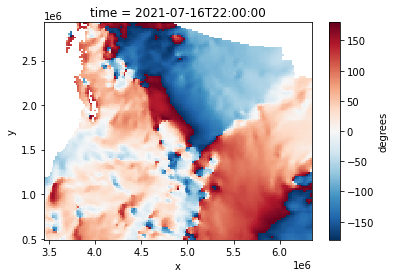

In [5]:
era_ds['degrees'].plot()

##  Setup UK  

In [6]:
nlags = 15
variogram_model = "spherical"

startTime = datetime.now()
krig = UniversalKriging(
    x=gpm25["Easting"],
    y=gpm25["Northing"],
    z=gpm25["PM2.5"],
    variogram_model=variogram_model,
    nlags=nlags,
    external_drift=era_ds['degrees'].values,
)
print(f"UK build time {datetime.now() - startTime}")



UK build time 0:02:53.619979


### Execute UK
Interpolate data to our grid using UK. 

In [7]:
startTime = datetime.now()
z, ss = krig.execute("grid", gridx, gridy)
print(f"UK execution time {datetime.now() - startTime}")
UK_pm25 = np.where(z < 0, 0, z)

# krig_ds["UK_pm25"] = (("y", "x"), UK_pm25)

UK execution time 0:00:04.813975


### Plot UK
Convert data to polygons to be plot-able on a slippy mapbox. This is not necessary but but :) 

polygons, values = pixel2poly(gridx, gridy, UK_pm25, resolution)
pm25_model = gpd.GeoDataFrame(
    {"Modelled PM2.5": values}, geometry=polygons, crs="EPSG:3347"
).to_crs("EPSG:4326")

fig = px.choropleth_mapbox(
    pm25_model,
    geojson=pm25_model.geometry,
    locations=pm25_model.index,
    color="Modelled PM2.5",
    color_continuous_scale="jet",
    center={"lat": 50., "lon": -110.},
    zoom=2.5,
    mapbox_style="carto-positron",
    opacity=0.8,
)
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.update_traces(marker_line_width=0)